In [34]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import collections
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from collections import Counter
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.semi_supervised import LabelSpreading
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from qns3vm import *
from scipy.sparse import csc_matrix
from sklearn.naive_bayes import MultinomialNB
from multinomial_model import MultinomialManyToOneEM
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [3]:
# Read and get information about Data
customer_data = pd.read_csv('Data.csv')

In [4]:
customer_data.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [5]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [6]:
print('Data rows and Columns:',customer_data.shape)

Data rows and Columns: (4459, 4993)


* The tagert value Y named 'Target' in the second Column, other Feature name doesn't mean anything for now

* Most of colums are full of zero from current perspective, it may can be femoved in futher processing

* Original Data has 4459 Data points and 4993 features, it may need operation for dimention reduction

# Checking Missing Values

In [7]:
def is_missing(data):
    missing_num =  data.columns[data.isnull().sum() != 0].size
    if missing_num != 0:
        missing_col = list(data.columns[data.isnull().sum() != 0])
        return missing_col
    else:
        print('There is no missing value in this Dataset')

is_missing(customer_data)

There is no missing value in this Dataset


# Remove Constant Columns From Data

In [8]:
def remove_constant(data):
    col_to_remove = []
    for col in data.columns:
        if col != 'ID' and col != 'target':
            if data[col].std() == 0:
                col_to_remove.append(col)
    return col_to_remove

In [9]:
remove_constant_col = remove_constant(customer_data)
customer_data.drop(remove_constant_col, axis = 1, inplace = True)  # Remove Constant Columns
print(remove_constant_col)
print('The number of column removed:',len(remove_constant_col))

['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e', '1352ddae5', '2b601ad67', '6e42ff7c7', '22196a84c', '0e410eb3d', '992e6d1d3', '90a742107', '08b9ec4ae', 'd95203ded'

* There are 256 columns having constant values has been removed

# Remove Duplicated Columns

In [10]:
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups    
    # Covert data to dict like structure for better manipulate
    dups = []

    for t, v in groups.items(): 

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):            
        # Search dupilicated columns column by column
            ia = vs.iloc[:,i].values
            for j in range(i+1, lcs):
                ja = vs.iloc[:,j].values
                if np.array_equal(ia, ja):
                    dups.append(cs[i])
                    break

    return dups   # Return duplicated columns

# Referance: https://www.kaggle.com/code/samratp/lightgbm-xgboost-catboost#XGB-Modeling

In [11]:
remove_duplicate_col = duplicate_columns(customer_data)
print('Duplicated columns are:',remove_duplicate_col)

Duplicated columns are: ['34ceb0081', '8d57e2749', '168b3e5bc', 'a765da8bc', 'acc5b709d']


In [12]:
customer_data.drop(remove_duplicate_col, axis = 1, inplace = True)

   When we say sparce data, it always refers to the columns in dataset which has many gaps present data being recorded,
i.e., most or all of them are zero. Althogh these data are functioning properly and valid but the actual reading is zero, which means these feature has no effect to result at all.  
   For example, if one feature in our data has bool value, and the probility for this to be true is only 0.01%, hence
produce sparce data.

## Handle Sparce Data

In [13]:
def drop_saprce(data):
    column_to_detect = [col for col in data.columns if col not in['ID','target']]
    counter = 0
    for col in column_to_detect:
        if len(np.unique(data[col])) < 2:
            data.drop(col, axis = 1, inplace = True)
            counter += 1
    print('The number of column has been droped is:', counter)
    return data

In [14]:
customer_data = drop_saprce(customer_data)

The number of column has been droped is: 0


# Split Train and Test Data

In [15]:
customer_data_X = customer_data.drop(['ID', 'target'], axis=1)
customer_data_Y = customer_data['target']

We will do classfication in this mission, now assign each data point a class

In [16]:
def Customer_Class(Data_Y):
    res = []
    Y = list(Data_Y)
    # Define Intervals for different Classes
    # Indicates for Low Value Customer and High Value Customer
    for v in Y:
        if v >=0 and v < 0.5e7:
            res.append('-1')
        else:
            res.append('1')
    print(collections.Counter(res))
    res = pd.DataFrame(res)
    return res[0]

In [17]:
customer_data_Y = Customer_Class(customer_data_Y)

Counter({'-1': 2890, '1': 1569})


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(customer_data_X, customer_data_Y, test_size = 0.2, random_state = 42)

(array([2306.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1261.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

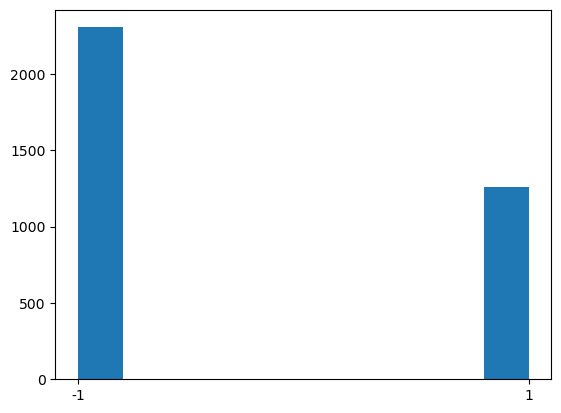

In [19]:
#See the distrubution of Y if it needs futher process
plt.hist(Y_train)

* Here we can see class is slightly Imbalanced, May need furtuer process 

# Split Train Data into Labeled and Unlabeled

* Data with Labed 1 and -1 will be used in EM algorithm and S3VM algorithm

In [20]:
def Semi_Dataset(Train_X, Train_Y, P = 0.15):
    Data = {}
    X_L, X_U, Y_L, Y_U = train_test_split(Train_X, Train_Y, test_size = (1-P), random_state = 42)
    Data['X_Labeled'] = X_L
    Data['X_Unlabeled'] = X_U
    Data['Y_Labeled'] = Y_L
    Data['Y_Unlabeled'] = Y_U
    return Data

In [21]:
Semi_Supervise_Learning_Data_Set = Semi_Dataset(X_train, Y_train)

In [22]:
# Data with Label 1 and -1
X_train_Labeled = Semi_Supervise_Learning_Data_Set['X_Labeled']
Y_train_Labeled = Semi_Supervise_Learning_Data_Set['Y_Labeled']
X_train_Unlabeled = Semi_Supervise_Learning_Data_Set['X_Unlabeled']

In [23]:
# Define Metric for evaluate performance of algorithms
def Make_Score_Cls(Test_Y,Pred_Y):
    res_ = {}
    res_['Accuracy'] = accuracy_score(Test_Y,Pred_Y)
    res_['Confusion_Matrix'] = confusion_matrix(Test_Y,Pred_Y)
    return res_

* Data with Labed 1 and 0 will be used in Self Learning and Label Spreading algorithm

In [24]:
def Class_Label_Self(Data_Y):
    res = []
    Y = list(Data_Y)
    # Define Intervals for different Classes
    # Indicates for Low Value Customer and High Value Customer
    for v in Y:
        if v >=0 and v < 0.5e7:
            res.append('0')      # Here we use 0 instead of 1 for Slef-Training
        else:
            res.append('1')
    print(collections.Counter(res))
    res = pd.DataFrame(res)
    return res[0]

In [25]:
Self_Learning_Y = Class_Label_Self(customer_data['target'])

Counter({'0': 2890, '1': 1569})


In [26]:
# Data with Label 1 and 0
X_train_SL, X_test_SL, Y_train_SL, Y_test_SL = train_test_split(customer_data.drop(['ID', 'target'], axis=1), 
                                                                Self_Learning_Y, 
                                                                test_size = 0.2, 
                                                                random_state = 42)
                                                            # Using Same random_state to get compareable result

# Baseline System: Self-Training Classifier (K Nearst Neightbor with default parameters)

In [311]:
def Self_Training_KNN(X_Train = X_train_SL, Y_Train = Y_train_SL, X_Test = X_test_SL, Y_Test = Y_test_SL, U_p = 0.15):
    rng = np.random.RandomState(42)
    Random_Unlable = rng.rand(len(Y_Train)) < U_p
    # Using defalut setting: 15% labeled data
    Y_Tr_Temp = list(Y_Train)
    # Make Unlabled Data
    for i,lab in enumerate(Y_Tr_Temp):
        if Random_Unlable[i] == True:
            continue
        else:
            Y_Tr_Temp[i] = -1
    Y_Train = pd.Series(Y_Tr_Temp).ravel()
    # Traing and evaluate Performance
    Model_KNN = KNeighborsClassifier(n_neighbors=3)
    ST_KNN = SelfTrainingClassifier(Model_KNN)
    ST_KNN.fit(X_Train, Y_Train)
    Y_Pred = ST_KNN.predict(X_Test)
    return Make_Score_Cls(Y_Test, Y_Pred)

In [308]:
def Self_Training_KNN_Learning_Curve(X_Train = X_train_SL, Y_Train = Y_train_SL):
    Unlabeled = np.linspace(0.01,0.8,150)
    Y_True = Y_Train
    # From 1% to 80%
    Acc = []
    for p in Unlabeled:
        rng = np.random.RandomState(42)
        Random_Unlable = rng.rand(len(Y_Train)) < p
        # Using defalut setting: 15% labeled data
        Y_Tr_Temp = list(Y_Train)
        # Make Unlabled Data
        for i,lab in enumerate(Y_Tr_Temp):
            if Random_Unlable[i] == True:
                continue
            else:
                Y_Tr_Temp[i] = -1
        Y_Train = pd.Series(Y_Tr_Temp).ravel()
        # Traing and evaluate Performance
        Model_KNN = KNeighborsClassifier(n_neighbors=3)
        ST_KNN = SelfTrainingClassifier(Model_KNN)
        ST_KNN.fit(X_Train, Y_Train)
        Y_Pred = ST_KNN.predict(X_Train)
        Acc.append(accuracy_score(Y_True, Y_Pred))
    sns.lineplot(x = Unlabeled, y = Acc) 

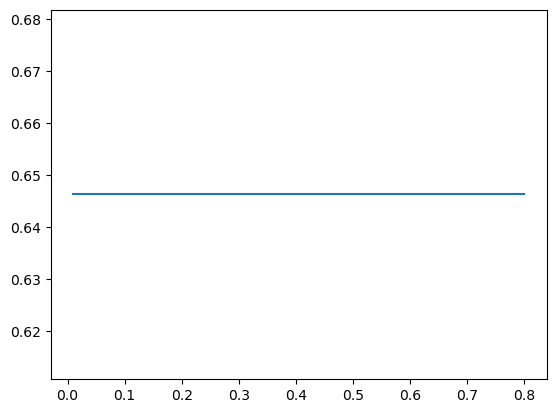

In [309]:
Self_Training_KNN_Learning_Curve()

* Here we can see there's almost no effect on the Baseline system about how many labeled datapoints we choose

# Label Spreading

In [28]:
def Lable_Spreading(X_Train = X_train_SL, Y_Train = Y_train_SL, U_p = 0.15):
    # Prepare for the Label Prediction
    rng = np.random.RandomState(42)
    Random_Unlable = rng.rand(len(Y_Train)) < U_p  # Unlabeled Portion
    # Using defalut setting: 15% labeled data
    Y_Tr_Temp = list(Y_Train)
    # Make Unlabled Data
    for i,lab in enumerate(Y_Tr_Temp):
        if Random_Unlable[i] == True:
            Y_Tr_Temp[i] = int(Y_Tr_Temp[i])
        else:
            Y_Tr_Temp[i] = -1
    Y_Train = pd.Series(Y_Tr_Temp).ravel()
    Label_Prop_Model = LabelSpreading()
    Label_Prop_Model.fit(X_Train, Y_Train)
    Y_Train_Pred = Label_Prop_Model.predict(X_Train)
    return Y_Train_Pred

* Here we can get some insights about the effect of the number of unlabeld data points

In [29]:
def Label_Spreading_Learning_Curve(Y_True = Y_train_SL):
    Y_True = [int(n) for n in Y_True]
    Unlabeled = np.linspace(0.001,0.8,150)
    Acc = []
    for p in Unlabeled:
        Cur_Pred = Lable_Spreading(U_p = p)
        Acc.append(accuracy_score(Y_True, Cur_Pred))
    sns.lineplot(x = Unlabeled, y = Acc)    

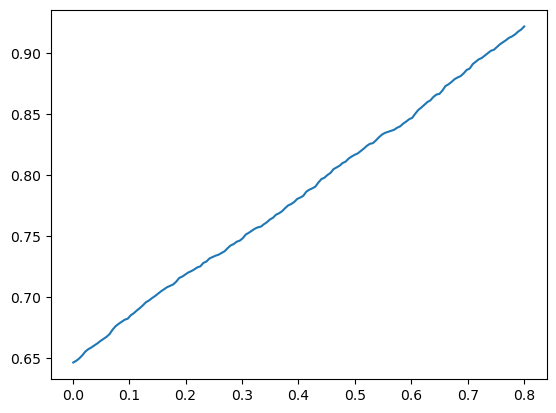

In [30]:
Label_Spreading_Learning_Curve()

* Here we can see as the number of Labled Data increases, The accuracy of prediction for labels are also increasing. However, in the real word, we may have no chance to get so much labeld data, to consider both perormance for the model and feasibility for real word problem, we will set Du = 15% through the probelm

In [31]:
Y_Train_Label_Spreading = Lable_Spreading()

Now we can train and evaluate the performance on differernt model

Here we will use Random Froest, XGBoost and LightGBM

## Random Froest Classifier (Label Spreading)

In [320]:
def Random_Froest_Classifier_Lable_Spreading(X_Train = X_train_SL, Y_Train = Y_Train_Label_Spreading, X_Test = X_test_SL, Y_Test = Y_test_SL):
    parm_grid_RF = {'n_estimators':[50,100,150,200],
                    'max_depth':[3,5,10,None],
                    'max_features':['sqrt','log2']}
    Kfold = KFold(n_splits=5,shuffle=True, random_state=42)
    score_RF = {'Accuracy':make_scorer(accuracy_score)}
    RF_grid = GridSearchCV(RandomForestClassifier(),param_grid = parm_grid_RF,cv = Kfold,
                           scoring = score_RF, refit = 'Accuracy')
    RF_grid.fit(X_Train, Y_Train)
    Best_RF = RF_grid.best_estimator_
    print('Best parameter for Random Froest is:',RF_grid.best_params_)
    Best_RF.fit(X_Train, Y_Train)
    Y_Pred = Best_RF.predict(X_Test)
    Y_Pred = [str(n) for n in Y_Pred]
    return Make_Score_Cls(Y_Test, Y_Pred)

In [321]:
Perf_RF = Random_Froest_Classifier_Lable_Spreading()

Best parameter for Random Froest is: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50}


## XGBoost Classifier (Label Spreading)

In [338]:
def XGBoost_Para(X_Train = X_train_SL, Y_Train = Y_Train_Label_Spreading):
    XGB_para = {'learning_rate':[0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
                'min_child_weight' : [ 1, 3, 5, 7 ],
                'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                'subsample': [0.5,0.6,0.7, 0.8],
                'colsample_bytree': [0.5, 0.6, 0.7, 0.8]}
    XGB_model = xgb.XGBClassifier(use_label_encoder = False)
    score_XGB = {'Accuracy':make_scorer(accuracy_score)}
    XGB_CV = GridSearchCV(XGB_model, param_grid = XGB_para, cv = 5,
                        scoring = score_XGB, refit = 'Accuracy' )
    XGB_CV.fit(X_Train, Y_Train)
    print(XGB_CV.best_params_)
    return XGB_CV.best_params_

In [340]:
XGB_Para = XGBoost_Para()

[17:46:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

In [ ]:
def XGB_Classifier_Lable_Spreading(X_Train = X_train_SL, Y_Train = Y_Train_Label_Spreading, X_Test = X_test_SL, Y_Test = Y_test_SL):
    XGB_Train_Data = xgb.DMatrix(X_Train,Y_Train)
    XGB_Test_Data =  xgb.DMatrix(X_Test)
    para = {}
    XGB_CLS = xgb.XGBClassifier(use_label_encoder = False)
    XGB_CLS.fit(X_Train, Y_Train)
    Y_Pred = XGB_CLS.predict(X_Test)
    Y_Pred = [str(n) for n in Y_Pred]
    return Make_Score_Cls(Y_Test, Y_Pred)

## Light GBM Classifier (Lable Spreading)

In [38]:
def LGBM_Para(X_Train = X_train_SL, Y_Train = Y_Train_Label_Spreading):
    LGBM_Model = lgb.LGBMClassifier(silent = True)
    LGB_paras = {'learning_rate': [0.001, 0.01, 0.1],
                 'min_data_in_leaf':[50,100,300,400],
                 'num_leaves': [20, 50, 80, 100, 120, 150],
                 'max_depth': [3, 5, 10, 15, 20],
                 'feature_fraction': [0.6, 0.8],
                 'bagging_fraction': [0.6, 0.8]}
    score_LGBM = {'Accuracy':make_scorer(accuracy_score)}
    LGBM_Grid = GridSearchCV(estimator = LGBM_Model, param_grid = LGB_paras, cv = 4,scoring = score_LGBM, refit = 'Accuracy')
    LGBM_Grid.fit(X_Train, Y_Train)
    print(LGBM_Grid.best_params_)
    return LGBM_Grid.best_params_   

In [39]:
LGBM_Para = LGBM_Para()

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fracti

In [40]:
LGBM_Para

{'bagging_fraction': 0.6,
 'feature_fraction': 0.6,
 'learning_rate': 0.001,
 'max_depth': 3,
 'min_data_in_leaf': 50,
 'num_leaves': 20}

In [ ]:
def LGBM_Classifier_Lable_Spreading(X_Train = X_train_SL, Y_Train = Y_Train_Label_Spreading, X_Test = X_test_SL, Y_Test = Y_test_SL):
    LGBM_Train_Data = lgb.Dataset(X_Train,Y_Train)
    LGBM_Test_Data =  lgb.Dataset(X_Test)
    para = {}
    LGBM_CLS = lgb.LGBMClassifier(silent = True)
    LGBM_CLS.fit(X_Train, Y_Train)
    Y_Pred = LGBM_CLS.predict(X_Test)
    Y_Pred = [str(n) for n in Y_Pred]
    return Make_Score_Cls(Y_Test, Y_Pred)